<a href="https://colab.research.google.com/github/skywalker0803r/oil_web/blob/master/%E8%BC%95%E6%B2%B9%E6%A1%88%E5%AD%90_modeling%E6%B5%81%E7%A8%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
#!pip install catboost
from google.colab import drive
drive.mount('/content/drive')
from sklearn.multioutput import MultiOutputRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import warnings;warnings.simplefilter('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate
from sklearn.linear_model import BayesianRidge, LinearRegression,Lasso,Ridge
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,max_error,make_scorer
from math import sqrt
from sklearn.manifold import isomap
from numpy import sqrt
import plotly.express as px
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# some function

In [0]:
def mape(a, b):
    a = np.array(a)
    b = np.array(b)
    mask = a != 0
    return (np.fabs(a-b)/a)[mask].mean()

def metric(y_t,y_p,name):
  res = {'R2' : max(r2_score(y_t,y_p), 0),
         'RMSE': sqrt(mean_squared_error(y_t,y_p)),
         'MAPE': mape(y_t,y_p)}
  return pd.DataFrame(res,index=[name])

# load data

In [43]:
data = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_250.csv',index_col=0)
train = data.loc[data.index %5 != 0]
test = data.loc[data.index %5 == 0]
test = test.drop(95,axis=0)
print(train.shape)
print(test.shape)

(200, 31)
(49, 31)


# N+A >= 36

In [44]:
def select_NaddA(df):
  condition=(df['N+A']>=36)
  return df.loc[condition]
test = select_NaddA(test)
print(train.shape)
print(test.shape)

(200, 31)
(43, 31)


# 定義欄位

In [45]:
cols = train.columns.tolist()
print(cols)

['DATE', 'N+A', 'T10', 'T50', 'T90', 'C5NP', 'C5IP', 'C5N', 'C6NP', 'C6IP', 'C6N', 'C6A', 'C7NP', 'C7IP', 'C7N', 'C7A', 'C8NP', 'C8IP', 'C8N', 'C8A', 'C9NP', 'C9IP', 'C9N', 'C9A', 'C10NP', 'C10IP', 'C10N', 'C10A', 'SUM', 'IBP', 'EBP']


In [0]:
features = ['IBP','T10','T50','T90','N+A','EBP']
y_columns = ['C5NP', 'C5IP', 'C5N', 
             'C6NP', 'C6IP', 'C6N', 'C6A', 
             'C7NP', 'C7IP', 'C7N', 'C7A', 
             'C8NP', 'C8IP', 'C8N', 'C8A', 
             'C9NP', 'C9IP', 'C9N', 'C9A', 
             'C10NP', 'C10IP', 'C10N', 'C10A']

# 定義x,y

In [0]:
X_train = train[features]
X_test = test[features]
y_train = train[y_columns]
y_test = test[y_columns]

# 產生溫差特徵

In [0]:
for df in [X_train,X_test]:
  df['T10-EBP'] = df['T10']-df['IBP']
  df['T50-T10'] = df['T50']-df['T10']
  df['T90-T50'] = df['T90']-df['T50']
  df['EBP-T90'] = df['EBP']-df['T90']

# 產生交互作用項

In [0]:
from sklearn.preprocessing import PolynomialFeatures
interaction = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_train = interaction.fit_transform(X_train)
X_train = pd.DataFrame(X_train,columns=interaction.get_feature_names())
X_test = interaction.transform(X_test)
X_test = pd.DataFrame(X_test,columns=interaction.get_feature_names())

# 平方

In [0]:
X_train = X_train**2
X_test = X_test**2

# StandardScaler

In [0]:
scaler_x = StandardScaler()
X_train[:] = scaler_x.fit_transform(X_train[:])
X_test[:] = scaler_x.transform(X_test[:])

# sort index

In [0]:
X_train = X_train.sort_index()
X_test = X_test.sort_index()
y_train = y_train.sort_index()
y_test = y_test.sort_index()

In [53]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(200, 55) (200, 23)
(43, 55) (43, 23)


In [0]:
svr = SVR()
cgb = CatBoostRegressor(n_estimators=100, learning_rate=0.1, verbose=0, objective='RMSE')
lasso = Lasso(0.1)

# model

In [0]:
model = Pipeline([('feature_selection',SelectFromModel(lasso)),('regressor',cgb)])

In [0]:
#model = StackingCVRegressor(regressors = (cgb,svr),
#                            meta_regressor = lasso,
#                            use_features_in_secondary = True) 

# 測試49筆

In [0]:
序列預測 = True

In [0]:
y_train_pred = pd.DataFrame(index = y_train.index,columns = y_columns)
y_pred = pd.DataFrame(index = y_test.index,columns = y_columns)
for y_name in y_columns:
  # fit
  model.fit(X_train.values,y_train[y_name].values)
  # predict 
  y_train_pred[y_name] = model.predict(X_train.values)
  y_pred[y_name] = model.predict(X_test.values)
  # 加入y當作特徵
  if 序列預測 == True:
    X_train[y_name] = y_train_pred[y_name].values
    X_test[y_name] = y_pred[y_name].values

In [59]:
y_pred.head()

,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,5.919927,3.987157,0.696128,6.296456,6.108262,6.836046,1.563035,5.827593,6.396171,11.358390,3.668949,5.257793,8.663310,6.638664,3.897867,2.281084,5.556560,2.588210,0.711589,0.164601,0.700225,0.057054,0.065710
5,1.342189,0.937474,0.253490,6.252515,6.140787,6.803021,1.121747,7.933716,8.482112,13.007328,3.487356,7.459801,10.055625,6.874109,4.771795,2.579454,6.725121,3.078236,0.662193,0.157002,0.739588,0.069168,0.192935
10,0.463002,0.221767,0.087788,0.128415,0.300723,4.738234,0.152213,6.251223,8.196795,23.079189,5.492862,4.579019,8.051154,10.176765,4.968220,1.992276,5.799814,4.587780,2.292070,0.552597,2.444955,0.496865,0.943782
15,10.881630,7.582083,0.916814,6.706104,8.269445,9.284042,3.405365,4.860251,4.531412,11.427076,4.431903,3.781002,4.182850,4.396491,3.666162,1.899691,3.167633,1.440774,0.995009,0.338082,0.864552,0.079539,0.146550
25,11.328733,7.551732,0.949307,6.910363,8.300608,9.453520,3.742827,4.857630,4.251774,12.199546,4.407693,3.708874,4.348478,4.326838,3.560688,1.813337,2.990620,1.398820,0.873076,0.467486,1.053292,0.121791,0.251681


In [60]:
res = pd.DataFrame()
for y_name in y_columns:
  res = res.append(metric(y_train[y_name],y_train_pred[y_name],y_name))
res.loc['AVG'] = res.mean()
res.style.background_gradient()

,R2,RMSE,MAPE
C5NP,0.994481,0.309955,1.07933
C5IP,0.988308,0.324459,0.78057
C5N,0.96414,0.0635665,0.448814
C6NP,0.976955,0.330658,0.325602
C6IP,0.984113,0.34656,0.613895
C6N,0.954745,0.40556,0.0632005
C6A,0.953212,0.266249,0.369202
C7NP,0.917344,0.308133,0.0445441
C7IP,0.964657,0.289086,0.0399381
C7N,0.986492,0.656817,0.0392305


In [61]:
res = pd.DataFrame()
for y_name in y_columns:
  res = res.append(metric(y_test[y_name],y_pred[y_name],y_name))
res.loc['AVG'] = res.mean()
res.style.background_gradient()

,R2,RMSE,MAPE
C5NP,0.974562,0.568848,0.221444
C5IP,0.932611,0.691791,0.396872
C5N,0.910924,0.0900488,0.374414
C6NP,0.933765,0.508322,0.225641
C6IP,0.924151,0.677159,0.249919
C6N,0.632827,1.5893,0.349847
C6A,0.823662,0.419324,0.745693
C7NP,0.75523,0.4498,0.066813
C7IP,0.666261,0.923805,0.112769
C7N,0.900795,1.85014,0.0766509


# loss analysis

In [0]:
y_name = 'C7N'

In [63]:
square_error = (y_pred[y_name]-y_test[y_name])**2
plot_data = pd.DataFrame()
plot_data[y_name] = y_test[y_name]
plot_data[y_name+'_pred'] = y_pred[y_name]
plot_data['loss'] = square_error
plot_data.sort_values(by='loss',ascending=False).head()

,C7N,C7N_pred,loss
10,29.654895,23.079189,43.239901
135,18.577741,13.475429,26.033592
145,17.906555,13.040204,23.681376
50,13.361280,10.870088,6.206038
35,8.729265,11.114974,5.691606


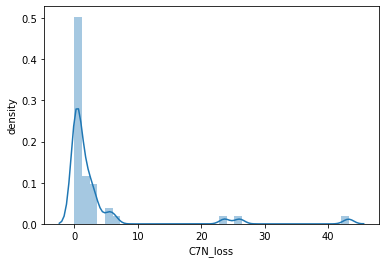

In [64]:
sns.distplot(square_error)
plt.xlabel(y_name+'_loss')
plt.ylabel('density')
plt.show()

Text(0, 0.5, 'square_error')

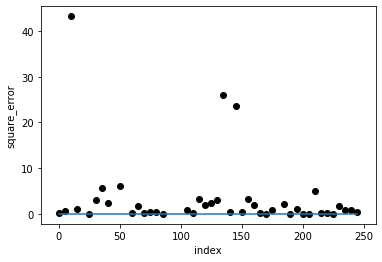

In [65]:
plt.plot(plot_data.index,[0 for i in range(len(plot_data))])
plt.scatter(plot_data.index,plot_data.loss,color='black')
plt.xlabel('index')
plt.ylabel('square_error')

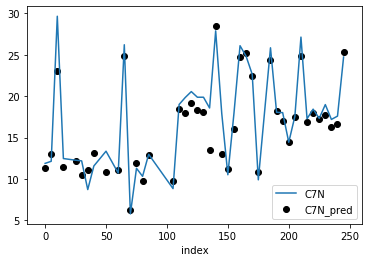

In [66]:
plt.plot(plot_data.index,plot_data[y_name],label = y_name)
plt.scatter(plot_data.index,plot_data[y_name+'_pred'],color='black',label = y_name+'_pred')
plt.xlabel('index')
plt.legend()
plt.show()